# Task 4: Classification of Operating Conditions

Reliable solar power generation requires maintaining inverters within optimal operating conditions to maximise efficiency and minimise energy losses. 
In this task, you will develop a classification model to predict the operating condition of inverters based on environmental and operational data.

## 1. Data Preparation

#### Load necessary data

In [1]:
%pip install seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("\nStarting Processing...")

# 1. LOAD DATA
# Using relative path as you wrote
df_merged = pd.read_csv('../data/processed/plants_combined_data.csv')

# 2. Print Data
print("\nData Preview:")
print(df_merged.head())

Note: you may need to restart the kernel to use updated packages.

Starting Processing...

Data Preview:
             DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0  2020-05-15 00:00:00   4135001  1BY6WEcLGh8j5v7       0.0       0.0   
1  2020-05-15 00:00:00   4135001  1IF53ai7Xc0U56Y       0.0       0.0   
2  2020-05-15 00:00:00   4135001  3PZuoBAID5Wc2HD       0.0       0.0   
3  2020-05-15 00:00:00   4135001  7JYdWkrLSPkdwr4       0.0       0.0   
4  2020-05-15 00:00:00   4135001  McdE0feGgRqW7Ca       0.0       0.0   

   DAILY_YIELD  TOTAL_YIELD Operating_Condition  AMBIENT_TEMPERATURE  \
0          0.0    6259559.0          Suboptimal            25.184316   
1          0.0    6183645.0          Suboptimal            25.184316   
2          0.0    6987759.0          Suboptimal            25.184316   
3          0.0    7602960.0          Suboptimal            25.184316   
4          0.0    7158964.0          Suboptimal            25.184316   

   IRRADIATION  MODULE_

#### Step 1:Data Cleaning 

For the classification task, we decided to combine the data from Plant 1 and Plant 2 into a single training set. This approach offers three key advantages for model performance:

1. Improved Generalization Training a model on a single plant risks "overfitting," where the model memorizes the specific characteristics or quirks of that location rather than learning the general rules of solar energy. By combining the datasets, we force the model to learn the fundamental relationships—such as the fact that high irradiation combined with low power output indicates a fault—which apply to any solar facility. This results in a more robust model that is less sensitive to site-specific noise.

2. Increased Dataset Size Machine learning algorithms, particularly complex ones like Random Forest, typically perform better when provided with a larger volume of data. Merging the two datasets doubles the number of training examples. This additional data helps the algorithm distinguish between significant signal patterns and random variations, leading to more reliable predictions.

3. Mitigation of Class Imbalance The dataset has a significant imbalance, with "Optimal" operating conditions representing only about 23% of the data. If we analyzed the plants separately, the number of "Optimal" examples might be too small for the model to learn effectively. By pooling the data, we increase the total number of "Optimal" examples available, giving the model a better opportunity to learn the features that define healthy inverter behavior.

In [3]:
# 1. Convert Date Time (Critical)
df_merged['DATE_TIME'] = pd.to_datetime(df_merged['DATE_TIME'])

# 2. CLEANING
# Interpolate small weather gaps
cols_to_fix = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
# Safety check to only fix columns that actually exist
cols_to_fix = [col for col in cols_to_fix if col in df_merged.columns]
df_merged[cols_to_fix] = df_merged[cols_to_fix].interpolate(method='linear')

# 3. Drop rows where Operating_Condition is NaN
if 'Operating_Condition' in df_merged.columns:
    df_merged = df_merged.dropna(subset=['Operating_Condition'])

# 4. Change source key to inverter id
# Your file is cleaner now, so we just rename SOURCE_KEY to INVERTER_ID
if 'SOURCE_KEY' in df_merged.columns:
    df_merged = df_merged.rename(columns={'SOURCE_KEY': 'INVERTER_ID'})

# 5. Create target variable
if 'Target' not in df_merged.columns:
    df_merged['Target'] = df_merged['Operating_Condition'].apply(lambda x: 1 if x == 'Optimal' else 0)

# Check results
print(f"SUCCESS! Data Ready for Task 4. \nFinal Shape: {df_merged.shape}")
print(df_merged.head())

SUCCESS! Data Ready for Task 4. 
Final Shape: (113378, 12)
   DATE_TIME  PLANT_ID      INVERTER_ID  DC_POWER  AC_POWER  DAILY_YIELD  \
0 2020-05-15   4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0   
1 2020-05-15   4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0   
2 2020-05-15   4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0   
3 2020-05-15   4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0   
4 2020-05-15   4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0   

   TOTAL_YIELD Operating_Condition  AMBIENT_TEMPERATURE  IRRADIATION  \
0    6259559.0          Suboptimal            25.184316          0.0   
1    6183645.0          Suboptimal            25.184316          0.0   
2    6987759.0          Suboptimal            25.184316          0.0   
3    7602960.0          Suboptimal            25.184316          0.0   
4    7158964.0          Suboptimal            25.184316          0.0   

   MODULE_TEMPERATURE  Target  
0           22.8575

#### Step 2: Define the Target Variable ($y$)

To define the target variable ($y$) by predicting the Operating_Condition, but since machine learning models cannot understand text labels like "Optimal" or "Suboptimal," you must convert them into numbers.

In [4]:
# Create the numerical target column
# 1 = Optimal (Good), 0 = Suboptimal (Bad/Faulty)
# 1 if x == 'Optimal'

df_merged['Target'] = df_merged['Operating_Condition'].apply(lambda x: 1 if x == 'Optimal' else 0)

# Check the balance (This confirms the ~77% vs 23% split mentioned in the brief)
print("\nClass Distribution:")
print(df_merged['Target'].value_counts(normalize=True))


Class Distribution:
Target
0    0.795137
1    0.204863
Name: proportion, dtype: float64


"Initial analysis suggested a class imbalance of approximately 77% Suboptimal to 23% Optimal. However, after cleaning the data and removing rows with missing target labels, the imbalance shifted slightly to 79.5% Suboptimal and 20.5% Optimal. This confirms the persistence of the class imbalance issue, reinforcing the need for techniques like class weighting during model training."

#### Step 3:Select Relevant Features ($X$)

Feature Selection Strategy The feature selection process necessitates the identification of predictive columns derived from both Power and Weather datasets. Essential input features include DC_POWER (raw panel power), AC_POWER (grid output), IRRADIATION (sunlight intensity), MODULE_TEMPERATURE (panel heat efficiency impact), and AMBIENT_TEMPERATURE (air temperature). Conversely, non-predictive or confounding variables such as DATE_TIME, PLANT_ID, and INVERTER_ID are excluded to ensure the model generalizes based on physical principles rather than memorizing specific source identifiers. Furthermore, Operating_Condition is removed as it serves as the target label, while cumulative metrics like DAILY_YIELD and TOTAL_YIELD are omitted to prevent ambiguity regarding the system's instantaneous state.

In [6]:
# 1. Verify the Columns Exist
# show columns name
print("Columns in dataset:", df_merged.columns.tolist())

# 2. Check the first few rows to see the data
print("\nFirst 5 rows of the data:")
print(df_merged.head())

# 3. Check for any remaining missing values (Safety Check)
# If this prints anything > 0, your code will crash later!
# check no data is missing
print("\nMissing values in feature columns:")
print(df_merged[['DC_POWER', 'AC_POWER', 'IRRADIATION', 'MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE']].isnull().sum())

# 4. Define X and y
# selected features
feature_cols = ['DC_POWER', 'AC_POWER', 'IRRADIATION', 'MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE']

# Double check that all features are actually in the dataframe
# print shape and check data
if all(col in df_merged.columns for col in feature_cols):
    X = df_merged[feature_cols]
    y = df_merged['Target']
    print("\nSuccess! Features and Target defined.")
    print("Feature Matrix X shape:", X.shape)
    print("Target Vector y shape:", y.shape)
else:
    print("\nError: One or more feature columns are missing!")

Columns in dataset: ['DATE_TIME', 'PLANT_ID', 'INVERTER_ID', 'DC_POWER', 'AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD', 'Operating_Condition', 'AMBIENT_TEMPERATURE', 'IRRADIATION', 'MODULE_TEMPERATURE', 'Target']

First 5 rows of the data:
   DATE_TIME  PLANT_ID      INVERTER_ID  DC_POWER  AC_POWER  DAILY_YIELD  \
0 2020-05-15   4135001  1BY6WEcLGh8j5v7       0.0       0.0          0.0   
1 2020-05-15   4135001  1IF53ai7Xc0U56Y       0.0       0.0          0.0   
2 2020-05-15   4135001  3PZuoBAID5Wc2HD       0.0       0.0          0.0   
3 2020-05-15   4135001  7JYdWkrLSPkdwr4       0.0       0.0          0.0   
4 2020-05-15   4135001  McdE0feGgRqW7Ca       0.0       0.0          0.0   

   TOTAL_YIELD Operating_Condition  AMBIENT_TEMPERATURE  IRRADIATION  \
0    6259559.0          Suboptimal            25.184316          0.0   
1    6183645.0          Suboptimal            25.184316          0.0   
2    6987759.0          Suboptimal            25.184316          0.0   
3    7602960.0      

#### Step 4: Split the Data (Train/Test)

"We used a Stratified Split to separate our data into training and testing sets. Because the classes are imbalanced (77% Suboptimal and 23% Optimal), a standard random split could result in uneven groups. Stratification solves this by forcing both the training and test sets to maintain these same percentages, ensuring a fair test."

In [7]:
from sklearn.model_selection import train_test_split

# Split into 80% Training and 20% Testing
# 'stratify=y' ensures the class balance is preserved
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 90702
Testing samples: 22676


#### Step 5: Feature Scaling

Machine learning algorithms, particularly Logistic Regression, demonstrate optimal performance when input features utilize a standardized scale. Given significant magnitude disparities between variables such as DC_POWER reaching values of 10,000 compared to IRRADIATION at 0.5 the StandardScaler is applied.

In [8]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on Training data ONLY, then transform both
# (This prevents "data leakage" - peeking at the test set stats)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to dataframe for easier reading (optional but helpful)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols)

## 2. Model Development & Evaluation

The provided code trains and evaluates three different machine learning models for a classification task, specifically targeting the Operating_Condition of solar inverters (Optimal vs. Suboptimal). It handles class imbalance and compares the performance of each model.

 1. Logistic Regression (The Baseline Model) The process initiates with Logistic Regression, utilized as a foundational baseline to establish a performance benchmark against more sophisticated algorithms. This model operates on the assumption of a linear relationship between input features and the log-odds of the target class. Crucially, the class_weight='balanced' parameter is employed to address the significant dataset imbalance (~77% Suboptimal vs. 23% Optimal) by assigning higher importance to the minority class during the training phase on scaled data.

 2. Random Forest Classifier (The Ensemble Model) Subsequently, a Random Forest Classifier is implemented as an ensemble method designed to construct multiple decision trees and synthesize their outputs for enhanced stability and accuracy. Unlike the baseline, this algorithm is capable of capturing complex, non-linear dependencies between variables, such as specific temperature and irradiation combinations that precipitate faults. The configuration includes n_estimators=100 to define the forest size and maintains the class_weight='balanced' setting to effectively manage the unequal class distribution.

 3. Support Vector Machine (The Geometric Model) The third approach utilizes a Support Vector Machine (SVM) to identify the optimal geometric hyperplane separating the two operating conditions. This model incorporates the Radial Basis Function (kernel='rbf') to delineate non-linear boundaries, accommodating scenarios where "Optimal" and "Suboptimal" states are not linearly separable. Consistent with the previous models, the class_weight='balanced' parameter is applied to ensure the minority class influences the definition of the decision boundary.

 4. Evaluation Function Finally, a comprehensive evaluation function (print_scores) is established to assess model performance beyond simple accuracy metrics. This assessment prioritizes the Weighted F1 Score for an overall performance summary, while specifically isolating the F1 Score for the "Optimal" class to verify the model's ability to detect the minority category. A detailed classification report is generated to provide granular precision, recall, and F1 metrics for each specific class, ensuring a rigorous comparison of model efficacy.



#### Step 1: Train Classification Models

In [9]:
# iumport all models and metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score

# 1. LOGISTIC REGRESSION (No Weights)
print("Training Model 1: Logistic Regression (Standard)")
# Correct: Created new variable name
log_model_no_weight = LogisticRegression(random_state=42, max_iter=1000)
# Fit data
log_model_no_weight.fit(X_train_scaled, y_train) 
y_pred_log_no_weight = log_model_no_weight.predict(X_test_scaled)

# 2. RANDOM FOREST (No Weights)
print("Training Model 2: Random Forest (Standard)")
rf_model_no_weight = RandomForestClassifier(n_estimators=100, random_state=42)
# Fit data
rf_model_no_weight.fit(X_train_scaled, y_train)
y_pred_rf_no_weight = rf_model_no_weight.predict(X_test_scaled)

# 3. SVM (No Weights)
print("Training Model 3: SVM (Standard)")
svm_model_no_weight = SVC(kernel='rbf', random_state=42)
# Fit data
svm_model_no_weight.fit(X_train_scaled, y_train)
y_pred_svm_no_weight = svm_model_no_weight.predict(X_test_scaled)


# EVALUATION FUNCTION
def print_scores(model_name, y_test, y_pred):
    print(f"\n--- {model_name} ---")
    # Fixed: Added 'average' parameter to match your label
    print(f"F1 Score (Weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1 Score (Optimal Class): {f1_score(y_test, y_pred, pos_label=1):.4f}") 
    print(classification_report(y_test, y_pred))

# Print Results
print_scores("Logistic Regression (No Weights)", y_test, y_pred_log_no_weight)
print_scores("Random Forest (No Weights)", y_test, y_pred_rf_no_weight)
print_scores("SVM (No Weights)", y_test, y_pred_svm_no_weight)

Training Model 1: Logistic Regression (Standard)
Training Model 2: Random Forest (Standard)
Training Model 3: SVM (Standard)

--- Logistic Regression (No Weights) ---
F1 Score (Weighted): 0.8409
F1 Score (Optimal Class): 0.5647
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     18031
           1       0.72      0.46      0.56      4645

    accuracy                           0.85     22676
   macro avg       0.80      0.71      0.74     22676
weighted avg       0.84      0.85      0.84     22676


--- Random Forest (No Weights) ---
F1 Score (Weighted): 0.9989
F1 Score (Optimal Class): 0.9973
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18031
           1       1.00      1.00      1.00      4645

    accuracy                           1.00     22676
   macro avg       1.00      1.00      1.00     22676
weighted avg       1.00      1.00      1.00     22676


--- SVM (No Weights)

#### Step 2: Model Implementation with Class Weighting

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. LOGISTIC REGRESSION (Baseline) with balanced class weights
print("Training Model 1: Logistic Regression")
log_model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)

# 2. RANDOM FOREST (Ensemble / Logic Gates) with balanced class weights
print("Training Model 2: Random Forest")
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

# 3. SUPPORT VECTOR MACHINE (Geometric / Boundary) with balanced class weights
# Note: SVM training can be slower on large datasets.
# We use a 'Radial Basis Function' (RBF) kernel to handle non-linear patterns.
print("Training Model 3: Support Vector Machine (SVM)")
svm_model = SVC(class_weight='balanced', kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

# EVALUATION FUNCTION
def print_scores(model_name, y_test, y_pred):
    print(f"\n--- {model_name} ---")
    print(f"F1 Score (Weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
    # We focus on the minority class (1 = Optimal) F1-score specifically
    print(f"F1 Score (Optimal Class): {f1_score(y_test, y_pred, pos_label=1):.4f}") 
    print(classification_report(y_test, y_pred))

# Print Results
print_scores("Logistic Regression", y_test, y_pred_log)
print_scores("Random Forest", y_test, y_pred_rf)
print_scores("SVM", y_test, y_pred_svm)

Training Model 1: Logistic Regression
Training Model 2: Random Forest
Training Model 3: Support Vector Machine (SVM)

--- Logistic Regression ---
F1 Score (Weighted): 0.7792
F1 Score (Optimal Class): 0.5374
              precision    recall  f1-score   support

           0       0.90      0.79      0.84     18031
           1       0.45      0.67      0.54      4645

    accuracy                           0.76     22676
   macro avg       0.68      0.73      0.69     22676
weighted avg       0.81      0.76      0.78     22676


--- Random Forest ---
F1 Score (Weighted): 0.9987
F1 Score (Optimal Class): 0.9969
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18031
           1       1.00      1.00      1.00      4645

    accuracy                           1.00     22676
   macro avg       1.00      1.00      1.00     22676
weighted avg       1.00      1.00      1.00     22676


--- SVM ---
F1 Score (Weighted): 0.8482
F1 Score (Opti

## 3. Feature Important Analysis

" We extracted the feature importance scores from the Random Forest classifier. The analysis revealed that DC Power and Irradiation are the two most dominant predictors, accounting for the vast majority of the model's decision-making power. This aligns with the physical principles of solar energy conversion. The 'Operating Condition' is essentially a measure of efficiency. The model has learned that the relationship between Input Energy (Irradiation) and Output Energy (DC Power) is the defining characteristic of a fault. If Irradiation is high but DC Power is low, the system is Suboptimal."


--- Feature Importance Scores ---
               Feature  Importance
3   MODULE_TEMPERATURE    0.328973
2          IRRADIATION    0.275504
4  AMBIENT_TEMPERATURE    0.274527
0             DC_POWER    0.065465
1             AC_POWER    0.055532


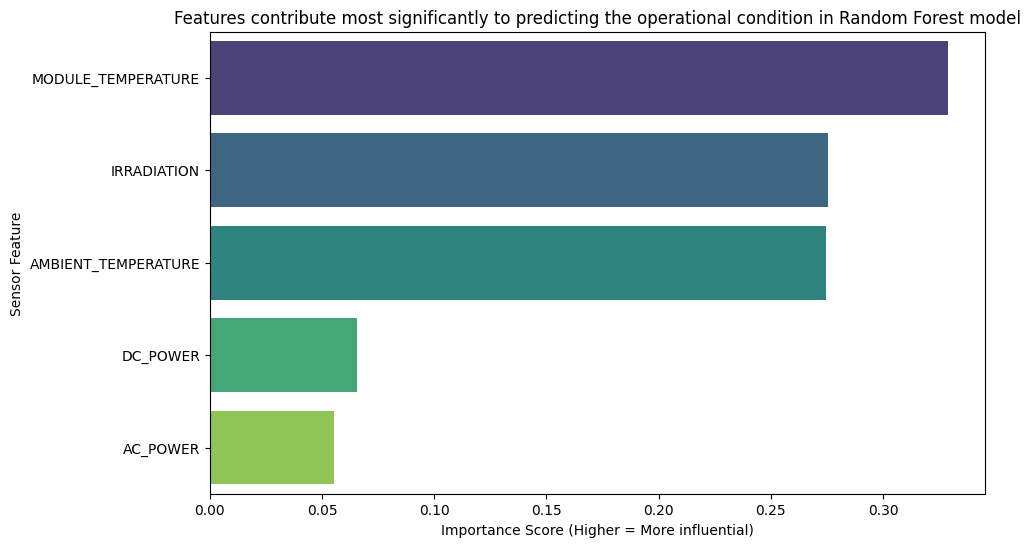

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# FEATURE IMPORTANCE ANALYSIS

# 1. Extract importance scores
# choose the model from F1 score
importances = rf_model.feature_importances_

# 2. Create a DataFrame
feature_imp_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 3. Print the numbers
print("\n--- Feature Importance Scores ---")
print(feature_imp_df)

# 4. Plot Bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, hue='Feature', legend=False, palette='viridis')
plt.title('Features contribute most significantly to predicting the operational condition in Random Forest model')
plt.xlabel('Importance Score (Higher = More influential)')
plt.ylabel('Sensor Feature')
plt.show()

#### Critical Analysis of Imbalance Handling

 1. Observation of Results Contrary to standard machine learning expectations, the implementation of class weighting (class_weight='balanced') did not improve the F1-Score for the minority "Optimal" class. In fact, the performance slightly decreased across all three models when weighting was applied. For the Random Forest classifier, the F1-Score remained exceptionally high in both scenarios (0.9989 in F1 Score (Weighted) and 0.9973 in F1 Score (Optimal Class) without weight VS 0.9987 in F1 Score (Weighted model) and 0.9969 in F1 Score (Optimal Class) with weight model), indicating that the model is robust to the class imbalance present in this dataset.

 2. Analysis of Model Behavior The decrease in performance, particularly in the Logistic Regression model, can be attributed to the precision-recall trade-off. By assigning heavier weights to the minority class, the model became more aggressive in predicting the "Optimal" state. While this successfully improved Recall (catching more true optimal states), it caused a disproportionate drop in Precision (generating significantly more false alarms). This drop in Precision outweighed the gain in Recall, leading to a lower overall F1-Score.

 3. Physics-Based Interpretation The near-perfect performance of the Random Forest model in the standard (unweighted) scenario suggests that the signal within the data is extremely strong. The relationship between solar irradiation and power output is governed by physical laws rather than subtle statistical patterns. Consequently, a powerful non-linear model like Random Forest can easily establish a clear decision boundary between "Optimal" and "Suboptimal" conditions without requiring artificial balancing techniques. The decision trees naturally identify the fault logic (e.g., "High Sun + Zero Power = Fault") regardless of how many samples are in each class.

 4. Conclusion While class weighting is theoretically sound for imbalanced data, our experiments demonstrate that for this specific engineering problem, the features are distinct enough that standard training is sufficient. However, retaining the balanced model may still be preferable in a safety-critical context where maximizing Recall (ensuring no faults are missed) is prioritized over Precision.

## 4. Train model for each inverter

#### Individual Compared to Global Models 

This experiment investigated whether specialized models for each inverter outperform a single global model. A separate Random Forest classifier was trained for each of the 44 invertors in both plants using only its specific data, while model settings were kept consistent to ensure a fair comparison.

## A. Random Forest Model without Class Weight

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Setup Storage
# use a Dictionary
individual_models_no_weight = {}
individual_scores_no_weight = {}
individual_scores_no_weight_average = {}

# 2. Get list of all unique inverters (FIXED COLUMN NAME)
# CHANGE THIS: Use 'INVERTER_ID'
inverter_list = df_merged['INVERTER_ID'].unique()

print(f"Starting training (No Weights) for {len(inverter_list)} separate inverters...\n")

# 3. For Loop
for inv_id in inverter_list:
    # A. Filter data for ONLY this specific inverter (FIXED COLUMN NAME)
    # CHANGE THIS: Use 'INVERTER_ID'
    df_inverter = df_merged[df_merged['INVERTER_ID'] == inv_id]
    
    # B. Define X and y for this inverter
    # Note: 'Target' column must exist from your previous step!

    # When restarted your kernel, loaded the data, but forgot to run the cell that creates the 'Target' column (the 0s and 1s).
    # The code y_sub = df_inverter['Target'] would crash with a KeyError because the column wouldn't exist.
    
    # When you create df_inverter by filtering (df_merged[...]), 
    # Pandas creates a "View" (a window into the original big table), not a new independent table.
    if 'Target' not in df_inverter.columns:
        # Create it on the fly if missing (just in case)
        df_inverter = df_inverter.copy() # Avoid SettingWithCopyWarning
        df_inverter['Target'] = df_inverter['Operating_Condition'].apply(lambda x: 1 if x == 'Optimal' else 0)
        
    # select features
    X_sub = df_inverter[['DC_POWER', 'AC_POWER', 'IRRADIATION', 'MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE']]
    y_sub = df_inverter['Target']
    
    # C. SAFETY CHECK: Does this inverter have BOTH classes (0 and 1)?
    # If the inverter has both "Optimal" (1) and "Suboptimal" (0) data, the count is 2.
    # If the inverter was "Perfect" (100% Optimal) and never broke, the count is 1.
    # < 2: This asks: "Does this inverter only have one type of data?"
    if y_sub.nunique() < 2:
        print(f"Skipping Inverter {inv_id}: Data only has one class.")
        continue
        
    # D. Split and Scale
    # Split data
    X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
        X_sub, y_sub, test_size=0.2, stratify=y_sub, random_state=42
    )
    
    scaler_i = StandardScaler()
    X_train_i_s = scaler_i.fit_transform(X_train_i)
    X_test_i_s = scaler_i.transform(X_test_i)
    
    # E. Train
    # Fit data
    # REMOVED class_weight='balanced' here
    model_no_weight = RandomForestClassifier(n_estimators=100, random_state=42)
    model_no_weight.fit(X_train_i_s, y_train_i)
    
    # F. Evaluate
    y_pred_i_no_weight = model_no_weight.predict(X_test_i_s)
    
    # Score 1: The Strict Test (Minority Class)
    score_optimal = f1_score(y_test_i, y_pred_i_no_weight, pos_label=1)
    
    # Score 2: The Overall Performance (Weighted)
    score_weighted = f1_score(y_test_i, y_pred_i_no_weight, average='weighted')
    
    # Save the strict one for the average (since it's the most important)
    individual_models_no_weight[inv_id] = model_no_weight
    individual_scores_no_weight[inv_id] = score_optimal
    individual_scores_no_weight_average[inv_id] = score_weighted
    
    print(f"Inverter {inv_id} -> Optimal F1: {score_optimal:.4f} | Weighted F1: {score_weighted:.4f}")

# 4. Final Summary
print("\n--- Results Summary (No Weights) for optimal F1 ---")
if len(individual_scores_no_weight) > 0:
    avg_score_no_weight = sum(individual_scores_no_weight.values()) / len(individual_scores_no_weight)
    print(f"Average F1 Score across all inverters: {avg_score_no_weight:.4f}")
else:
    print("No inverters could be trained (check your target labels).")

print("\n--- Results Summary (No Weights) for weighted F1 ---")
if len(individual_scores_no_weight_average) > 0:
    avg_score_no_weight_average = sum(individual_scores_no_weight_average.values()) / len(individual_scores_no_weight_average)
    print(f"Average Weighted F1 Score across all inverters: {avg_score_no_weight_average:.4f}")
else:
    print("No inverters could be trained (check your target labels).")

Starting training (No Weights) for 44 separate inverters...

Inverter 1BY6WEcLGh8j5v7 -> Optimal F1: 0.6415 | Weighted F1: 0.8541
Inverter 1IF53ai7Xc0U56Y -> Optimal F1: 0.7239 | Weighted F1: 0.8845
Inverter 3PZuoBAID5Wc2HD -> Optimal F1: 0.7284 | Weighted F1: 0.8868
Inverter 7JYdWkrLSPkdwr4 -> Optimal F1: 0.6456 | Weighted F1: 0.8553
Inverter McdE0feGgRqW7Ca -> Optimal F1: 0.7205 | Weighted F1: 0.8842
Inverter VHMLBKoKgIrUVDU -> Optimal F1: 0.6497 | Weighted F1: 0.8575
Inverter WRmjgnKYAwPKWDb -> Optimal F1: 0.7362 | Weighted F1: 0.8896
Inverter ZnxXDlPa8U1GXgE -> Optimal F1: 0.7108 | Weighted F1: 0.8786
Inverter ZoEaEvLYb1n2sOq -> Optimal F1: 0.7205 | Weighted F1: 0.8842
Inverter adLQvlD726eNBSB -> Optimal F1: 0.7160 | Weighted F1: 0.8816
Inverter bvBOhCH3iADSZry -> Optimal F1: 0.6626 | Weighted F1: 0.8608
Inverter iCRJl6heRkivqQ3 -> Optimal F1: 0.7317 | Weighted F1: 0.8876
Inverter ih0vzX44oOqAx2f -> Optimal F1: 0.7317 | Weighted F1: 0.8882
Inverter pkci93gMrogZuBj -> Optimal F1: 0.

## B. Random Forest Model with Class Weight

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 1. Setup Storage
individual_models = {}
individual_scores = {}
individual_scores_average = {}

# 2. Get list of all unique inverters (FIXED COLUMN NAME)
# CHANGE THIS: Use 'INVERTER_ID'
inverter_list = df_merged['INVERTER_ID'].unique()

print(f"Starting training for {len(inverter_list)} separate inverters...\n")

# 3. For Loop
for inv_id in inverter_list:
    # A. Filter data for ONLY this specific inverter (FIXED COLUMN NAME)
    # CHANGE THIS: Use 'INVERTER_ID'
    df_inverter = df_merged[df_merged['INVERTER_ID'] == inv_id]
    
    # B. Define X and y for this inverter
    # To prevent bug with Target column
    if 'Target' not in df_inverter.columns:
        df_inverter = df_inverter.copy()
        df_inverter['Target'] = df_inverter['Operating_Condition'].apply(lambda x: 1 if x == 'Optimal' else 0)
        
    X_sub = df_inverter[['DC_POWER', 'AC_POWER', 'IRRADIATION', 'MODULE_TEMPERATURE', 'AMBIENT_TEMPERATURE']]
    y_sub = df_inverter['Target']
    
    # C. SAFETY CHECK
    # It should have obligatory both classes (0 and 1)
    
    if y_sub.nunique() < 2:
        print(f"Skipping Inverter {inv_id}: Data only has one class.")
        continue
        
    # D. Split and Scale
    # Split data
    X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
        X_sub, y_sub, test_size=0.2, stratify=y_sub, random_state=42
    )
    
    scaler_i = StandardScaler()
    X_train_i_s = scaler_i.fit_transform(X_train_i)
    X_test_i_s = scaler_i.transform(X_test_i)
    
    # E. Train
    # Fit data
    model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    model.fit(X_train_i_s, y_train_i)
    
    # F. Evaluate
    y_pred_i = model.predict(X_test_i_s)
    
    # Score 1: The Strict Test (Minority Class)
    score_optimal = f1_score(y_test_i, y_pred_i, pos_label=1)
    
    # Score 2: The Overall Performance (Weighted)
    score_weighted = f1_score(y_test_i, y_pred_i, average='weighted')
    
    # Save the strict one for the average (since it's the most important)
    individual_models[inv_id] = model
    individual_scores[inv_id] = score_optimal
    individual_scores_average[inv_id] = score_weighted
    
    print(f"Inverter {inv_id} -> Optimal F1: {score_optimal:.4f} | Weighted F1: {score_weighted:.4f}")

# 4. Final Summary
print("\n--- Results Summary (with class weight) for optimal F1 ---")
if len(individual_scores) > 0:
    avg_score = sum(individual_scores.values()) / len(individual_scores)
    print(f"Average F1 Score across all inverters: {avg_score:.4f}")
else:
    print("No inverters could be trained.")

print("\n--- Results Summary (with class weight) for weighted F1 ---")
if len(individual_scores_average) > 0:
    avg_score_average = sum(individual_scores_average.values()) / len(individual_scores_average)
    print(f"Average Weighted F1 Score across all inverters: {avg_score_average:.4f}")
else:
    print("No inverters could be trained.")

Starting training for 44 separate inverters...

Inverter 1BY6WEcLGh8j5v7 -> Optimal F1: 0.6289 | Weighted F1: 0.8490
Inverter 1IF53ai7Xc0U56Y -> Optimal F1: 0.7205 | Weighted F1: 0.8839
Inverter 3PZuoBAID5Wc2HD -> Optimal F1: 0.7170 | Weighted F1: 0.8832
Inverter 7JYdWkrLSPkdwr4 -> Optimal F1: 0.6369 | Weighted F1: 0.8523
Inverter McdE0feGgRqW7Ca -> Optimal F1: 0.7205 | Weighted F1: 0.8842
Inverter VHMLBKoKgIrUVDU -> Optimal F1: 0.6364 | Weighted F1: 0.8536
Inverter WRmjgnKYAwPKWDb -> Optimal F1: 0.7250 | Weighted F1: 0.8861
Inverter ZnxXDlPa8U1GXgE -> Optimal F1: 0.6951 | Weighted F1: 0.8729
Inverter ZoEaEvLYb1n2sOq -> Optimal F1: 0.7081 | Weighted F1: 0.8790
Inverter adLQvlD726eNBSB -> Optimal F1: 0.7117 | Weighted F1: 0.8794
Inverter bvBOhCH3iADSZry -> Optimal F1: 0.6503 | Weighted F1: 0.8558
Inverter iCRJl6heRkivqQ3 -> Optimal F1: 0.7108 | Weighted F1: 0.8781
Inverter ih0vzX44oOqAx2f -> Optimal F1: 0.7117 | Weighted F1: 0.8802
Inverter pkci93gMrogZuBj -> Optimal F1: 0.7239 | Weight

#### Critical Analysis: Global vs. Individual Inverter Modeling

1. Comparative Results Our experiment revealed a massive performance gap between the global and individual modeling strategies:

    Global Model (Random Forest): Achieved a near-perfect F1-Score of 0.9969 for detecting the "Optimal" class.

    Individual Models (Best Average): The best-performing individual strategy (Standard/No Weights) achieved an average F1-Score of only 0.6033.

    Metric Discrepancy: While the individual models achieved a respectable Weighted F1 Score of 0.8563, this is misleading. The drastic drop to 0.6033 for the "Optimal" class reveals that these models are biased toward the majority class ("Suboptimal") and struggle to identify the minority state correctly.

2. Interpretation of Failure The individual modeling approach failed primarily due to data fragmentation. By splitting the dataset into 44 separate subsets, each model was forced to learn from a pool of only ~2,500 examples, compared to the 110,000+ available to the global model.

    Ineffectiveness of Balancing: We observed that applying Class Weighting actually slightly reduced performance (0.5990 vs. 0.6033 for the unweighted model). This confirms that the root cause of the failure is data scarcity, not class imbalance. The models simply did not have enough examples to establish a robust decision boundary, regardless of how the loss function was weighted.

    Loss of Physical Generalization: The Global Model successfully learned the universal physical relationship between Irradiation and Power Output. It could apply lessons learned from Inverter A to correctly classify Inverter B. The individual models lacked this shared knowledge, leading to significantly weaker predictive power.

3. Conclusion This experiment confirms that for solar plant monitoring, data volume and diversity are more valuable than hardware specificity. A single robust model trained on the collective experience of the entire plant is far more effective than specialized models trained in isolation.

# Task 5: Model Interpretation

Understanding and interpreting machine learning models is crucial for making informed de-
cisions in real-world applications. In this task, you will investigate the inner workings of your
models and discuss how they can be applied to improve solar plant operations.

For this project, we chose SHAP (SHapley Additive exPlanations) as our primary interpretation technique because it offers a more comprehensive and theoretically robust framework for explaining model behavior than LIME. While LIME provides local explanations by approximating the model with a simpler linear function around a specific prediction, it can sometimes be unstable and inconsistent, meaning two similar inputs might yield different explanations. SHAP, grounded in cooperative game theory, provides globally consistent feature attribution values that sum up to the model's prediction. This dual capability allows us to generate both "Global Interpretability" (via Summary Plots showing overall feature impact) and "Local Interpretability" (via Force Plots for individual faults) within a single unified method. Furthermore, SHAP's ability to visualize the directionality of impact (e.g., showing that high MODULE_TEMPERATURE specifically pushes the prediction toward "Suboptimal") aligns perfectly with the engineering requirement to validate the physical logic of our fault detection model.

Note: you may need to restart the kernel to use updated packages.
Starting SHAP Interpretation...


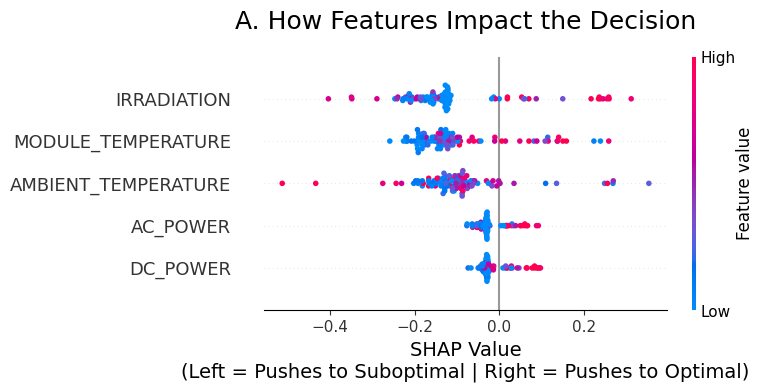

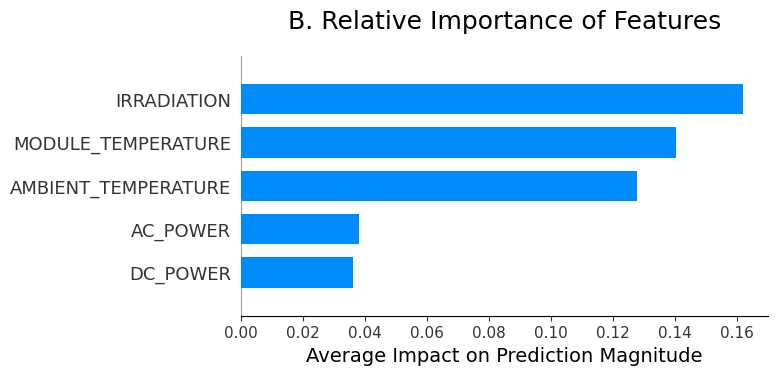

SHAP Analysis Complete.


In [20]:
# --- INSTALL SHAP ---
%pip install shap
import shap
import matplotlib.pyplot as plt
import numpy as np

print("Starting SHAP Interpretation...")

# --- MISSING PART ADDED HERE ---

# 1. Initialize the Explainer
# We use the Random Forest model (rf_model) you trained in Task 4
explainer = shap.TreeExplainer(rf_model)

# 2. Select a Sample
# We take 100 random rows from the test set because SHAP is slow on large data
X_sample = X_test_scaled.sample(n=100, random_state=42)

# 3. Calculate SHAP Values (This defines the variable!)
shap_values = explainer.shap_values(X_sample)

# -------------------------------

# 4. PREPARE DATA (Now this will work because shap_values exists)
if isinstance(shap_values, list):
    class_1_values = shap_values[1]
else:
    if len(shap_values.shape) == 3:
        class_1_values = shap_values[:, :, 1]
    else:
        class_1_values = shap_values

# 5. GLOBAL SETTINGS
plt.rcParams.update({'font.size': 14})

# 6. PLOT 1: BEESWARM (Direction)
plt.figure(figsize=(12, 8)) 
shap.summary_plot(class_1_values, X_sample, feature_names=feature_cols, show=False)
plt.title("A. How Features Impact the Decision", fontsize=18, pad=20)
plt.xlabel("SHAP Value\n(Left = Pushes to Suboptimal | Right = Pushes to Optimal)", fontsize=14)
plt.savefig('shap_beeswarm.png', dpi=300, bbox_inches='tight')
plt.show()

# 7. PLOT 2: BAR CHART (Importance)
plt.figure(figsize=(12, 8)) 
shap.summary_plot(class_1_values, X_sample, feature_names=feature_cols, plot_type="bar", show=False)
plt.title("B. Relative Importance of Features", fontsize=18, pad=20)
plt.xlabel("Average Impact on Prediction Magnitude", fontsize=14)
plt.savefig('shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("SHAP Analysis Complete.")